In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
# from pyspark.sql.types import *
# from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

24/05/04 13:53:26 WARN Utils: Your hostname, Kiraras-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.3.200 instead (on interface en0)
24/05/04 13:53:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/04 13:53:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
import pandas as pd

df = pd.read_parquet("labeled_post.parquet")

In [5]:
len(df)

80571

24/05/04 13:53:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [7]:
df_small = df[:1000].copy()

In [8]:
sdf = spark.createDataFrame(df[['id', 'title', 'selftext']])

/Users/kirarak/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [9]:
sdf_small = spark.createDataFrame(df_small[['id', 'title', 'selftext']])

/Users/kirarak/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


# Demonym

In [10]:
# demonym library
# https://github.com/porimol/countryinfo?tab=readme-ov-file
# !pip install countryinfo

In [11]:
from countryinfo import CountryInfo

country = CountryInfo()
countries = country.all()

In [12]:
len(countries)

234

In [13]:
# countries['japan']

In [14]:
countries['japan']['demonym']

'Japanese'

In [15]:
demonyms = {}
for country, info in countries.items():
    country_name = country.lower()
    demonym = info.get('demonym', '').lower()

    if demonym:
        demonyms[demonym] = demonym
    demonyms[country_name] = demonym

In [16]:
import re
from collections import defaultdict


def clean(text):
    clean_text = text.lower()
    clean_text = re.sub(r"[()/,.\s]", " ", clean_text)
    clean_text = re.sub(r"\s{2,}", " ", clean_text)
    return clean_text


def count_demonyms(row):
    text = row["selftext"]
    words = clean(text).split()
    word_index = defaultdict(set)
    for i, word in enumerate(words):
        word_index[word].add(i)

    demonym_index = defaultdict(list)
    for word, index in word_index.items():
        for demonym_word, demonym in demonyms.items():
            if word == demonym_word:
                demonym_index[demonym] += list(index)

    demonym_counts = {k:len(set(v)) for k, v in demonym_index.items()}
    return (row["id"], demonym_counts)

In [17]:
%%time
# 5min
# df['demonyms'] = df.selftext.apply(count_demonyms)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs


In [18]:
%%time
# 1m14s
demonyms_results = sdf.rdd.map(count_demonyms).collect()

24/05/04 13:57:18 WARN TaskSetManager: Stage 0 contains a task of very large size (15259 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 53.2 ms, sys: 11.3 ms, total: 64.5 ms
Wall time: 24.8 s


In [19]:
len(demonyms_results)

80571

In [20]:
df_demonyms = pd.DataFrame(demonyms_results, columns=["id", "demonyms"])
df_demonyms.head()

,id,demonyms
0,1284npp,{}
1,1284q84,{}
2,1284sqm,{}
3,1284trz,{}
4,128509j,{}


In [21]:
df = df.merge(df_demonyms, left_on="id", right_on="id")

In [22]:
df['demonyms_words_count'] = df.demonyms.apply(lambda x: sum(x.values()))

In [23]:
df.sort_values(by="demonyms_words_count", ascending=False).head()

,link_flair_text,num_comments,over_18,score,url,selftext,title,id,edited,is_self,permalink,downs,ups,created,date,demonyms,demonyms_words_count
45930,Not the A-hole,1,False,1,https://www.reddit.com/r/AmItheAsshole/comment...,I'm German and I was traveling last weekend th...,AITA for telling an american guy that he shoul...,15y7mlh,0.0,True,/r/AmItheAsshole/comments/15y7mlh/aita_for_tel...,0.0,1,1.692715e+09,2023-08-22,"{'german': 16, 'spanish': 1, 'american': 6}",23
10170,Not the A-hole,37,False,36,https://www.reddit.com/r/AmItheAsshole/comment...,My wife's dad is Spanish and she lived a few y...,AITA for asking my wife to ask her Spanish spe...,139191v,0.0,True,/r/AmItheAsshole/comments/139191v/aita_for_ask...,0.0,36,1.683320e+09,2023-05-05,"{'spanish': 12, 'swedish': 10}",22
53145,Asshole,1,False,1,https://www.reddit.com/r/AmItheAsshole/comment...,I am going to write this as neutral as possibl...,"AITA for being upset that my spouse spent $15,...",16g9jjf,0.0,True,/r/AmItheAsshole/comments/16g9jjf/aita_for_bei...,0.0,1,1.694471e+09,2023-09-11,{'jordanian': 22},22
27581,No A-holes here,51,False,8,https://www.reddit.com/r/AmItheAsshole/comment...,My partner (23F) and I (21F) are travelling in...,AITA for asking my partner to stop insulting B...,14qu5rx,0.0,True,/r/AmItheAsshole/comments/14qu5rx/aita_for_ask...,0.0,8,1.688513e+09,2023-07-04,"{'spanish': 5, 'british': 5, 'french': 3, 'iri...",22
76170,Everyone Sucks,19,False,6,https://www.reddit.com/r/AmItheAsshole/comment...,"I am from Tuva, its a republic within Russia t...",AITA for calling someone at my university a du...,18cydj7,0.0,True,/r/AmItheAsshole/comments/18cydj7/aita_for_cal...,0.0,6,1.701964e+09,2023-12-07,"{'russian': 8, 'mongolian': 2, 'czech': 3, 'tu...",22


In [24]:
df.groupby(by="demonyms_words_count").size().to_frame().head()

,0
demonyms_words_count,
0,75830
1,2835
2,886
3,374
4,224


In [25]:
len(df.loc[df.demonyms_words_count > 0]), len(df.loc[df.demonyms_words_count == 0]), len(df)

(4741, 75830, 80571)

In [26]:
100 * len(df.loc[df.demonyms_words_count > 0]) / len(df)

5.884251157364313

<Axes: xlabel='demonyms_words_count'>

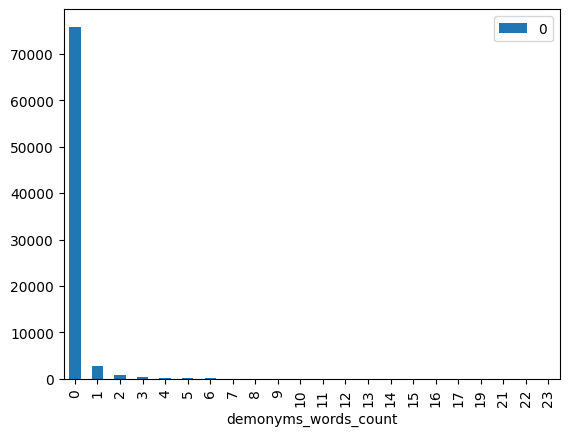

In [27]:
df.groupby(by="demonyms_words_count").size().to_frame().plot.bar()

<Axes: xlabel='demonyms_words_count'>

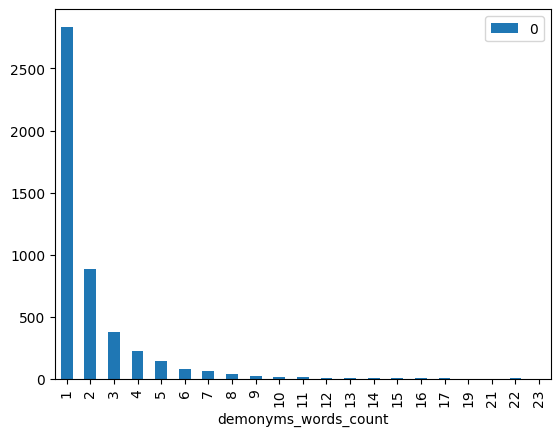

In [28]:
df.loc[df.demonyms_words_count > 0].groupby(by="demonyms_words_count").size().to_frame().plot.bar()

In [29]:
df['demonyms_unique_count'] = df.demonyms.apply(lambda x: len(x.keys()))

In [30]:
df.sort_values(by="demonyms_unique_count", ascending=False).head()

,link_flair_text,num_comments,over_18,score,url,selftext,title,id,edited,is_self,permalink,downs,ups,created,date,demonyms,demonyms_words_count,demonyms_unique_count
76170,Everyone Sucks,19,False,6,https://www.reddit.com/r/AmItheAsshole/comment...,"I am from Tuva, its a republic within Russia t...",AITA for calling someone at my university a du...,18cydj7,0.000000e+00,True,/r/AmItheAsshole/comments/18cydj7/aita_for_cal...,0.0,6,1.701964e+09,2023-12-07,"{'russian': 8, 'mongolian': 2, 'czech': 3, 'tu...",22,11
27581,No A-holes here,51,False,8,https://www.reddit.com/r/AmItheAsshole/comment...,My partner (23F) and I (21F) are travelling in...,AITA for asking my partner to stop insulting B...,14qu5rx,0.000000e+00,True,/r/AmItheAsshole/comments/14qu5rx/aita_for_ask...,0.0,8,1.688513e+09,2023-07-04,"{'spanish': 5, 'british': 5, 'french': 3, 'iri...",22,10
28504,Everyone Sucks,22,False,1,https://www.reddit.com/r/AmItheAsshole/comment...,"Hello redditors,\nI am sharing a flat with a f...",WIBTA if I kick my flatmate because of his sme...,14t8hfh,1.688786e+09,True,/r/AmItheAsshole/comments/14t8hfh/wibta_if_i_k...,0.0,1,1.688739e+09,2023-07-07,"{'cameroonian': 2, 'moroccan': 3, 'german': 2,...",12,8
67232,Not the A-hole,23,False,28,https://www.reddit.com/r/AmItheAsshole/comment...,Sorry for any mistakes my first time posting.\...,AITA For getting upset when my boyfriends fami...,17mfiuh,1.698965e+09,True,/r/AmItheAsshole/comments/17mfiuh/aita_for_get...,0.0,28,1.698964e+09,2023-11-02,"{'mexican': 1, 'german': 1, 'cuban': 3, 'colom...",15,7
61701,Not the A-hole,1,False,1,https://www.reddit.com/r/AmItheAsshole/comment...,For some context my (20F)’s family liked to tr...,AITA for not wanting to learn Spanish with my ...,175kdeo,0.000000e+00,True,/r/AmItheAsshole/comments/175kdeo/aita_for_not...,0.0,1,1.697047e+09,2023-10-11,"{'hungarian': 1, 'french': 1, 'german': 1, 'ja...",13,6


In [31]:
df.groupby(by="demonyms_unique_count").size().to_frame().head()

,0
demonyms_unique_count,
0,75830
1,3934
2,604
3,152
4,33


<Axes: xlabel='demonyms_unique_count'>

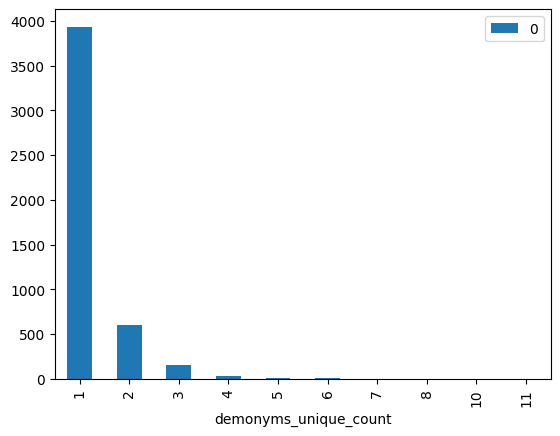

In [32]:
df.loc[df.demonyms_words_count > 0].groupby(by="demonyms_unique_count").size().to_frame().plot.bar()

# Linguistic

In [33]:
# https://github.com/zacanger/profane-words
!wget https://raw.githubusercontent.com/zacanger/profane-words/master/words.json

--2024-05-04 13:57:43--  https://raw.githubusercontent.com/zacanger/profane-words/master/words.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38088 (37K) [text/plain]
Saving to: ‘words.json’

words.json          100%[===================>]  37.20K  --.-KB/s    in 0.001s  

2024-05-04 13:57:43 (35.2 MB/s) - ‘words.json’ saved [38088/38088]



In [34]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import json
import nltk

nltk.download('stopwords')
nltk.download('punkt')

stopwords_set = set(stopwords.words('english'))


with open("words.json") as f:
    profane_words = set(json.load(f))

def create_features(row):
    title = row["title"]
    post = row["selftext"]
    
    features = {
        "title_uppercase_count": 0,
        "title_word_count": 0,
        "title_profanity_count": 0,
        "avg_word_length": 0,
        "stop_word_count": 0,
        "numerics_count": 0,
        "uppercase_words_count": 0,
        "sentence_count": 0,
        "avg_sentence_length": 0,
        "profanity_count": 0,
    }
    
    # Title features
    title_words = word_tokenize(title)
    features['title_uppercase_count'] = sum(1 for c in title if c.isupper())
    features['title_word_count'] = len(title.split())
    features['title_profanity_count'] = sum(1 for word in title_words if word.lower() in profane_words)

    # Post features
    words = word_tokenize(post)
    sentences = sent_tokenize(post)
    features['avg_word_length'] = sum(len(word) for word in words) / len(words) if words else 0
    features['stop_word_count'] = sum(1 for word in words if word.lower() in stopwords_set)
    features['numerics_count'] = sum(1 for word in words if word.isdigit())
    features['uppercase_words_count'] = sum(1 for word in words if word.isupper())
    features['sentence_count'] = len(sentences)
    features['avg_sentence_length'] = sum(len(sentence.split()) for sentence in sentences) / len(sentences) if sentences else 0
    features['profanity_count'] = sum(1 for word in words if word.lower() in profane_words)

    return row["id"], features


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirarak/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/kirarak/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [35]:
%%time
# 1000 records = 3m3s
# df_small['features'] = df.apply(create_features, axis=1)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [38]:
%%time
# 80k records = 52s
features_results = sdf.rdd.map(create_features).collect()

24/05/04 13:58:52 WARN TaskSetManager: Stage 2 contains a task of very large size (15259 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 114 ms, sys: 95.1 ms, total: 209 ms
Wall time: 29.3 s


In [41]:
len(features_results)

80571

In [42]:
df_features = pd.DataFrame(features_results, columns=["id", "features"])

In [43]:
df = df.merge(df_features, left_on="id", right_on="id")

In [44]:
df = df.join(pd.json_normalize(df['features']))

In [45]:
df.head()

,link_flair_text,num_comments,over_18,score,url,selftext,title,id,edited,is_self,...,title_uppercase_count,title_word_count,title_profanity_count,avg_word_length,stop_word_count,numerics_count,uppercase_words_count,sentence_count,avg_sentence_length,profanity_count
0,Not the A-hole,1155,False,9597,https://www.reddit.com/r/AmItheAsshole/comment...,"I (26 F) am married to K (25 M) , i met him a ...",AITA for embarrassing my husband in front of h...,1284npp,0.000000e+00,True,...,4,10,0,3.392857,269,6,13,16,28.437500,0
1,Not the A-hole,19,False,8,https://www.reddit.com/r/AmItheAsshole/comment...,Story is just as stupid as the title.\n\nSo my...,AITA from eating a cookie,1284q84,0.000000e+00,True,...,4,5,0,3.348525,195,8,15,13,25.615385,0
2,Not the A-hole,21,False,13,https://www.reddit.com/r/AmItheAsshole/comment...,My roommate (about to be 27 F) and me (20F) ha...,AITA for yelling at my roommate to stop touchi...,1284sqm,1.680309e+09,True,...,4,11,0,3.625000,170,2,31,18,17.333333,2
3,Not the A-hole,13,False,10,https://www.reddit.com/r/AmItheAsshole/comment...,"So as you all know, tomorrow is April Fool’s D...",WIBTA to play an April Fool’s prank on my brot...,1284trz,0.000000e+00,True,...,7,10,0,3.097222,147,1,16,21,10.666667,0
4,Asshole,90,False,73,https://www.reddit.com/r/AmItheAsshole/comment...,Using a throwaway because my sister has reddit...,AITA for joking with my sister in front of her...,128509j,0.000000e+00,True,...,4,11,0,3.734967,212,0,22,31,12.516129,3


In [46]:
df.to_parquet("labeled_post_features.parquet")

In [47]:
df.columns

Index(['link_flair_text', 'num_comments', 'over_18', 'score', 'url',
       'selftext', 'title', 'id', 'edited', 'is_self', 'permalink', 'downs',
       'ups', 'created', 'date', 'demonyms', 'demonyms_words_count',
       'demonyms_unique_count', 'features', 'title_uppercase_count',
       'title_word_count', 'title_profanity_count', 'avg_word_length',
       'stop_word_count', 'numerics_count', 'uppercase_words_count',
       'sentence_count', 'avg_sentence_length', 'profanity_count'],
      dtype='object')